### Naive attempt 

A minimal thought brute force effort at using gpytorch to map for gliders. 
We will only map in time, and not care about the fact that the glider moves in space. 

In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import gsw

In [2]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

In [3]:
ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [4]:
dens_659 = gsw.sigma0(ds_659.salinity, ds_659.temperature)
dens_660 = gsw.sigma0(ds_660.salinity, ds_660.temperature)
ds_659['density'] = xr.DataArray(
            data=dens_659,
            coords=ds_659.coords,
            dims=ds_659.dims,
            name='density'
        )

ds_660['density'] = xr.DataArray(
            data=dens_660,
            coords=ds_660.coords,
            dims=ds_660.dims,
            name='density'
        )

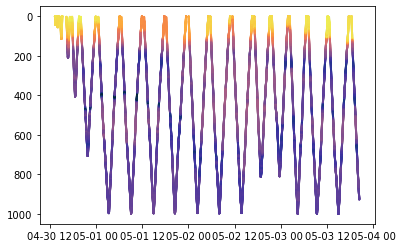

In [5]:
npts = 50000

temp= ds_659.isel(ctd_data_point=slice(0,npts))

plt.scatter(temp.time, temp.pressure, c = temp.temperature, s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

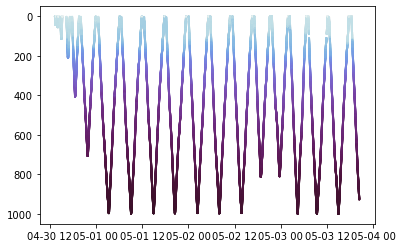

In [6]:
npts = 50000

temp= ds_659.isel(ctd_data_point=slice(0,npts))

plt.scatter(temp.time, temp.pressure, c = temp.density, s=1, 
            cmap=cmo.dense, vmin=26.7, vmax=27.6)

plt.gca().invert_yaxis()

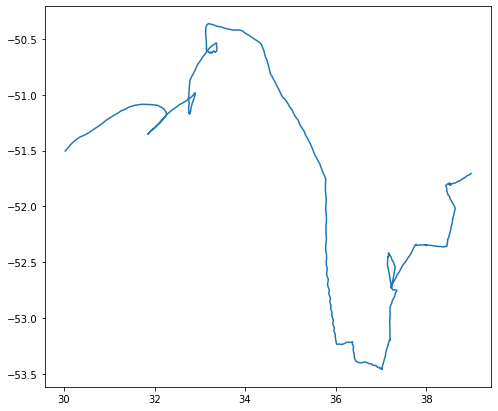

In [7]:
plt.figure(figsize=(8,7))
plt.plot(ds_659.longitude.groupby(ds_659.dives).mean(),
         ds_659.latitude.groupby(ds_659.dives).mean())

In [8]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [9]:
lon_659 = ds_659.longitude.groupby(ds_659.dives).mean()
lat_659 = ds_659.latitude.groupby(ds_659.dives).mean()

In [10]:
# convert lat-lon to local tangent plane 

origin_lat = -53.5 #S
origin_lon = 29.5  #E

X_659 = great_circle_distance(origin_lon, lat_659, 
                          lon_659, lat_659)*110
Y_659 = great_circle_distance(lon_659, origin_lat, 
                          lon_659, lat_659)*110

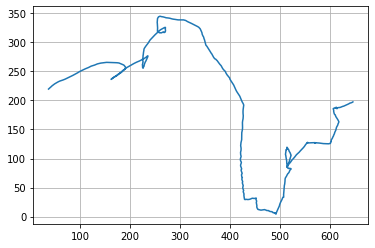

In [11]:
plt.plot(X_659, Y_659)
plt.grid()

In [12]:
X_659_simple = (lon_659 - origin_lon)*110*np.cos(lat_659*np.pi/180)
Y_659_simple = (lat_659 - origin_lat)*110

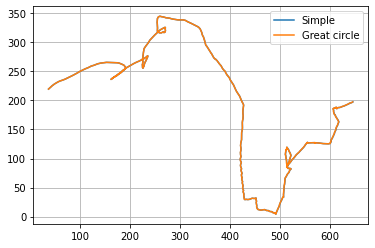

In [13]:
plt.plot(X_659_simple, Y_659_simple, label='Simple')
plt.plot(X_659, Y_659, label='Great circle')
plt.grid()
plt.legend()

In [14]:
time_659 = ds_659.time.groupby(ds_659.dives).mean() - np.datetime64('2019-01-01')
time_659 = (time_659 / np.timedelta64(1,'D'))

In [15]:
density_659 = ds_659.density.where(ds_659.pressure>800).groupby(ds_659.dives).mean()

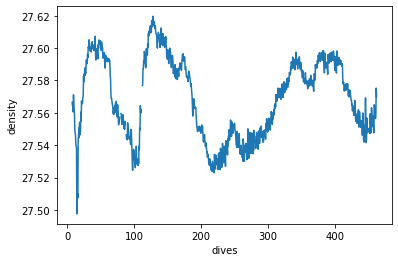

In [16]:
density_659.plot()

In [17]:
# remove all nans from the data 

# convert to arrays like X and y.

# X - time, lat (y in km), lon (x in km) and length of number of data points 

In [18]:
x = np.zeros((len(time_659), 1))

In [19]:
# coordinates of samples 
x[:,0] = time_659.values
#x[:,1] = X_659.values
#x[:,2] = Y_659.values

y = density_659.values

In [20]:
#x_xarr = xr.DataArray(x, dims=['sample_num','coordinate'], 
#                     coords=[range(len(time_659)), ['t','x','y']])
x_xarr = xr.DataArray(x, dims=['sample_num','coordinate'], 
                     coords=[range(len(time_659)), ['t']])

In [21]:
y_xarr = xr.DataArray(y, dims=['sample_num'],
                     coords=[range(len(time_659))])

In [22]:
x_xarr_nonans = x_xarr.where(~np.isnan(y_xarr), drop=True)
y_xarr_nonans = y_xarr.where(~np.isnan(y_xarr), drop=True)

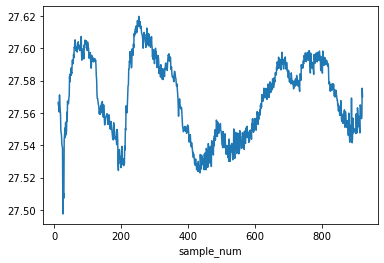

In [23]:
y_xarr_nonans.plot()

In [24]:
import gpytorch
import torch

In [25]:
# convert to torch tensors, since that is what PyTorch and GPyTorch work with.
train_x = torch.from_numpy(x_xarr_nonans.values).float()
train_y = torch.from_numpy(y_xarr_nonans.values).float()

In [40]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=7)
#        self.covar_module = (
#                             gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) + 
#                             gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5)) )# +
#                             gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()) 
                            #)
        
#        self.covar_module.kernels[0].outputscale = 10.
#        self.covar_module.kernels[1].outputscale = 1
        #self.covar_module.kernels[2].outputscale = 1.
#        self.covar_module.kernels[0].base_kernel.lengthscale = 10.
#        self.covar_module.kernels[1].base_kernel.lengthscale = 1.
        #self.covar_module.kernels[1].base_kernel.lengthscale = 10.
        #self.covar_module.kernels[1].base_kernel.period_length = 0.5
        #self.covar_module.kernels[2].base_kernel.lengthscale = 10.
        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [52]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = (
                             gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) + 
                             gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5)) )# +
#                             gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()) 
                            #)
        
        self.covar_module.kernels[0].outputscale = 10.
        self.covar_module.kernels[1].outputscale = 1
        #self.covar_module.kernels[2].outputscale = 1.
        self.covar_module.kernels[0].base_kernel.lengthscale = 10.
        self.covar_module.kernels[1].base_kernel.lengthscale = 1.
        #self.covar_module.kernels[1].base_kernel.lengthscale = 10.
        #self.covar_module.kernels[1].base_kernel.period_length = 0.5
        #self.covar_module.kernels[2].base_kernel.lengthscale = 10.
        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [53]:
# initialize likelihood and model
likelihood_adam = gpytorch.likelihoods.GaussianLikelihood()
likelihood_lbfgs = gpytorch.likelihoods.GaussianLikelihood()
likelihood_lbfgs.noise_covar.noise=.001
model_adam = ExactGPModel(train_x, train_y, likelihood_adam)
model_lbfgs = ExactGPModel(train_x, train_y, likelihood_lbfgs)

In [54]:
for param_name, param in model_lbfgs.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -7.012665748596191
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.kernels.0.raw_outputscale     value = 9.999954223632812
Parameter name: covar_module.kernels.0.base_kernel.raw_lengthscale value = 9.999954223632812
Parameter name: covar_module.kernels.1.raw_outputscale     value = 0.5413248538970947
Parameter name: covar_module.kernels.1.base_kernel.raw_lengthscale value = 0.5413248538970947


In [55]:
#hypers = {
#    'likelihood.noise_covar.noise': torch.tensor(.1),
#    'covar_module.kernels.0.base_kernel.lengthscale': torch.tensor([10.]),
#    'covar_module.kernels.0.outputscale': torch.tensor(10.),
#}
#model_adam.initialize(**hypers);
#model_lbfgs.initialize(**hypers);

In [56]:
import sys
sys.path.append('../../../python_packages/PyTorch-LBFGS/functions/')
from LBFGS import FullBatchLBFGS

Iter 1/100 - Loss: 36.237  
Iter 11/100 - Loss: 10.256  
Iter 21/100 - Loss: 4.603  
Iter 31/100 - Loss: 2.928  
Iter 41/100 - Loss: 2.129  
Iter 51/100 - Loss: 1.578  
Iter 61/100 - Loss: 1.032  
Iter 71/100 - Loss: 0.457  
Iter 81/100 - Loss: -0.110  
Iter 91/100 - Loss: -0.581  


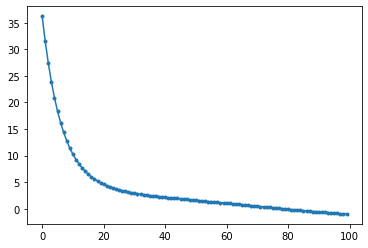

In [30]:
# Find optimal model hyperparameters
model_adam.train() 
likelihood_adam.train();
# these calls set the model and likelihood into training modes 
# (they don't actually train anything)
# Use the adam optimizer
optimizer = torch.optim.Adam([
                {'params': model_adam.parameters()},  # Includes GaussianLikelihood parameters
                              ], lr=0.1) # set learning rate of 0.1

# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_adam, model_adam)


training_iter = 100 # set as many stels as we want to take 

loss_vals = np.zeros(training_iter)
for i in range(training_iter):
    
        # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = model_adam(train_x)

    # Calc loss and backprop gradients
    # loss is defined is -log(p(Y(x)))

    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, train_y)

    loss.backward()
    
    if np.mod(i,10)==0:
        print(#'Iter %d/%d - Loss: %.3f   lengthscale1: %.3f lengthscale2: %.3f lengthscale3: %.3f  noise: %.3f' % (
            'Iter %d/%d - Loss: %.3f  ' % (
            i + 1, training_iter, loss.item(),
            #model_adam.covar_module.base_kernel.lengthscale[0][0].item(),
            #model_adam.covar_module.base_kernel.lengthscale[0][1].item(),
            #model_adam.covar_module.base_kernel.lengthscale[0][2].item(),
            #model_adam.likelihood.noise.item()
              ))
    loss_vals[i] = loss.item()
        
    optimizer.step()
    
plt.plot(loss_vals, marker='.')

In [57]:
print('Noise std: ', model_adam.likelihood.noise_covar.noise.item()**0.5)
print('Scale kernel: ',model_adam.covar_module.kernels[0].outputscale.item())
print('Length/time scales: ',model_adam.covar_module.kernels[0].base_kernel.lengthscale)
print('Scale kernel: ',model_adam.covar_module.kernels[1].outputscale.item())
print('Length/time scales: ',model_adam.covar_module.kernels[1].base_kernel.lengthscale)

Noise std:  0.8326146762209592
Scale kernel:  10.0
Length/time scales:  tensor([[10.]], grad_fn=<SoftplusBackward>)
Scale kernel:  1.0
Length/time scales:  tensor([[1.]], grad_fn=<SoftplusBackward>)


Iter 1/20 - Loss: -0.348 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log_Noise: 0.001
Iter 2/20 - Loss: -0.857 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log_Noise: 0.000
Iter 3/20 - Loss: -1.677 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log_Noise: 0.000
Iter 4/20 - Loss: -2.103 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log_Noise: 0.000
Iter 5/20 - Loss: -2.331 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log_Noise: 0.000
Iter 6/20 - Loss: -2.345 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log_Noise: 0.000
Iter 7/20 - Loss: -2.406 - LR: 0.002 - Func Evals: 5 - Grad Evals: 1 - Log_Noise: 0.000
Iter 8/20 - Loss: -2.398 - LR: 0.000 - Func Evals: 12 - Grad Evals: 1 - Log_Noise: 0.000
Iter 9/20 - Loss: -2.238 - LR: 0.000 - Func Evals: 12 - Grad Evals: 2 - Log_Noise: 0.000
Iter 10/20 - Loss: -2.350 - LR: 0.042 - Func Evals: 3 - Grad Evals: 1 - Log_Noise: 0.000
Iter 11/20 - Loss: -2.392 - LR: 0.000 - Func Evals: 7 - Grad Evals: 1 - Log_Noise: 0.000
Iter 12/20 - Loss: -2.398 - 

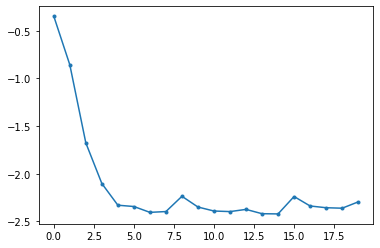

In [58]:
# Find optimal model hyperparameters
model_lbfgs.train() 
likelihood_lbfgs.train();
# these calls set the model and likelihood into training modes 
# (they don't actually train anything)
# Use the adam optimizer
optimizer = FullBatchLBFGS(model_lbfgs.parameters())


# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_lbfgs, model_lbfgs)

# define closure
def closure():
    optimizer.zero_grad()
    output = model_lbfgs(train_x)
    loss = -mll(output, train_y)
    return loss

loss = closure()
loss.backward()

training_iter = 20
loss_vals = np.zeros(training_iter)

for i in range(training_iter):

    # perform step and update curvature
    options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
    loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(options)

#    print('Iter %d/%d - Loss: %.3f   lengthscale1: %.3f noise: %.3f' % (
#            i + 1, training_iter, loss.item(),
#            model.covar_module.base_kernel.lengthscale[0][0].item(),
#            model.likelihood.noise.item()
#              ))
    loss_vals[i] = loss.item()
    print(#'Iter %d/%d - Loss: %.3f - LR: %.3f - Func Evals: %0.0f - Grad Evals: %0.0f - Log-Lengthscale: %.3f - Log_Noise: %.3f' % (
        'Iter %d/%d - Loss: %.3f - LR: %.3f - Func Evals: %0.0f - Grad Evals: %0.0f - Log_Noise: %.3f' % (
        i + 1, training_iter, loss.item(), lr, F_eval, G_eval,
        #model_lbfgs.covar_module.base_kernel.lengthscale[0][0].item(),
        model_lbfgs.likelihood.noise.item()
        ))
    
plt.plot(loss_vals, marker='.')

In [59]:
print('Noise std: ', model_lbfgs.likelihood.noise_covar.noise.item()**0.5)
print('Scale kernel: ',model_lbfgs.covar_module.kernels[0].outputscale.item())
print('Length/time scales: ',model_lbfgs.covar_module.kernels[0].base_kernel.lengthscale)
print('Scale kernel: ',model_lbfgs.covar_module.kernels[1].outputscale.item())
print('Length/time scales: ',model_lbfgs.covar_module.kernels[1].base_kernel.lengthscale)


Noise std:  0.010014727572161458
Scale kernel:  15.128807067871094
Length/time scales:  tensor([[10.9314]], grad_fn=<SoftplusBackward>)
Scale kernel:  0.005013762041926384
Length/time scales:  tensor([[7.4996]], grad_fn=<SoftplusBackward>)


## Code runsand makes reasonable looking parameters!

In [72]:
# A bit convoluted to create test points for this. Let's try it with actual data in depth. 

In [60]:
test_pts = train_x

In [61]:
# Get into evaluation (predictive posterior) mode
# this is the specific way that PyTorch works, basically sort
# of like freezing parameters, stop tracking gradients.
#model_adam.eval()
#likelihood_adam.eval();
model_lbfgs.eval()
likelihood_lbfgs.eval();

In [62]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    #observed_pred = likelihood_adam(model_adam(test_pts))
    observed_pred = likelihood_lbfgs(model_lbfgs(test_pts))

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [63]:
mean_obs = observed_pred.mean
var_obs  = observed_pred.variance
samp1    = observed_pred.sample()

In [64]:
lower, upper = observed_pred.confidence_region()

In [65]:
temp = train_x.detach().numpy()
mean_obs = mean_obs.detach().numpy()
samp1 = samp1.detach().numpy()

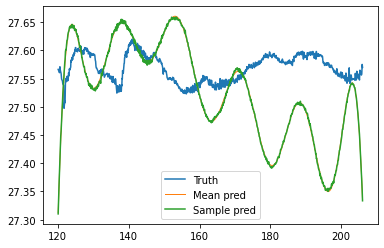

In [67]:
plt.plot(temp[:,0], y_xarr_nonans, label='Truth')
plt.plot(temp[:,0], mean_obs, label='Mean pred', linewidth=1)
#plt.plot(temp[:,0], samp1, label='Sample pred')
#plt.xlim([120, 140])
plt.legend()